In [64]:
%load_ext autoreload
%autoreload 2

# to enable imports from parent package
import sys
import os
from pathlib import Path
parent_dir = Path(os. getcwd()).parent.absolute()
sys.path.append(str(parent_dir))

import torch
import numpy as np
import os.path as osp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from models import load_model
from models.args import Args
from datasets.ogb_util import load_ogb_dataset, split_ogb_dataset
from plots import aggregate_over_splits, remove_unused_categories, palette, model_types, group, remove_top_percentage, groupby_to_table, rename_col, concatenate, append_model_type, compute_baseline_score

import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt


device = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')


plots_dir = 'output'
dataset_name = "ogbg-molhiv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda


In [65]:
from tqdm import tqdm
from run_attacks import all_tasks

results_directory = '../results/'

# tasks_to_load = ["original", "bruteforce"]
# filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
# attack_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items()}

# attack_tasks = all_tasks

def load_data(all_tasks, dataset_name, tasks_to_load=[], sortby=["model", "task", "id"], apply_transform=None):
    data = []

    if tasks_to_load:
        filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
        all_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items() if dataset_name in model_name}

    for model_name, tasks in tqdm(all_tasks.items()):
        # if not dataset_name in model_name:
        #     continue
        model_type = model_name.split("_")[0]
        dataset = model_name.split("_")[1]

        for task_name, task in tasks.items():
            path = osp.join(results_directory, dataset, model_name, f"{task_name}.data")
            if not osp.exists(path):
                continue

            df = pd.read_pickle(path)
            if apply_transform is not None:
                    df = apply_transform(df)
            data.append(df)
            # try:
            #     df = pd.read_pickle(path)
            #     data.append(df)
            # except Exception as e:
            #     print(f"ERROR when reading task '{task_name}' of '{model_name}'")
            #     print(e)

    def short_model_names_map(df, prefix_len=1):
        model_names = set(df["model"].values)
        count = {}
        rename_map = {}
        for model_name in model_names:
            prefix = "_".join(model_name.split("_")[:prefix_len])
            if not prefix in count:
                count[prefix] = 0
            rename_map[model_name] = f"{prefix}_{count[prefix]}"
            count[prefix] += 1
        return rename_map

    data = concatenate(data)
    data.sort_values(sortby, inplace=True)
    data = data.reset_index(drop=True)
    model_name_map = short_model_names_map(data)
    data["model"] = data["model"].cat.rename_categories(model_name_map)
    data["model_rep"] = [int(x[-1]) for x in data["model"]]
    append_model_type(data)
    data = data[~data["id"].isna()]
    data["id"] = data["id"].astype("int32")

    if (data["is_undirected"] == 0).any():
        mask = data["is_undirected"] == 0
        print("found directed perturbation")
        print(data[mask])
    # assert (data["is_undirected"] == 1).all()

    data["acc"] = 1 - data["missclassified"]

    return data


## Original Data

In [66]:
orig_data = load_data(all_tasks, "ogbg-molhiv", ["original"])

pd.pivot_table(orig_data[["model_type", "y"]], columns="model_type", aggfunc="count") # should all be 20565

100%|██████████| 40/40 [00:00<00:00, 734.14it/s]

model_type,Baseline,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
y,20565,20565,20565,20565,20565,20565,20565,20565


In [67]:
from ogb.graphproppred import Evaluator

def compute_OGB_score_per_model(df, groupby="model", eval_criterion="rocauc"):
    data = {}
    data["model"] = []

    evaluator = Evaluator(dataset_name)
    groups = dict(list(df.groupby(groupby)))
    for group, group_df in groups.items():
        y_true = np.array(group_df["y"]).reshape(-1, 1)
        y_pred = np.array(group_df["pred"]).reshape(-1, 1)
        input_dict = {"y_true": y_true, "y_pred": y_pred}

        data["model"].append(group)
        for crit, score in evaluator.eval(input_dict).items():
            if crit not in data:
                data[crit] = []
            data[crit].append(score)

    return pd.DataFrame(data)


# compute_OGB_score_per_model(orig_data)

,model_type,rocauc,acc,lbl_diff
0,Baseline,$0.722 \pm 0.012$,$0.967 \pm 0.002$,$0.066 \pm 0.004$
1,DropGINE,$0.771 \pm 0.009$,$0.967 \pm 0.001$,$0.051 \pm 0.002$
2,ESAN,$0.727 \pm 0.02$,$0.964 \pm 0.006$,$0.068 \pm 0.02$
3,GIN,$0.749 \pm 0.007$,$0.967 \pm 0.003$,$0.054 \pm 0.009$
4,GINE,$0.757 \pm 0.035$,$0.965 \pm 0.002$,$0.072 \pm 0.023$
5,PPGN,$0.756 \pm 0.008$,$0.968 \pm 0.001$,$0.052 \pm 0.009$
6,SignNet,$0.723 \pm 0.019$,$0.965 \pm 0.003$,$0.057 \pm 0.003$
7,meanGINE,$0.77 \pm 0.005$,$0.968 \pm 0.001$,$0.05 \pm 0.004$


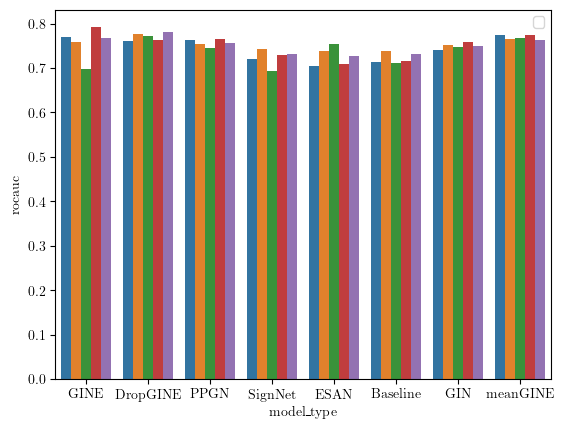

In [68]:
orig_per_model = group(orig_data, ["model"]).mean().reset_index()
append_model_type(orig_per_model)
orig_per_model = orig_per_model[["model", "model_type", "lbl_diff", "acc", "model_rep"]]
orig_per_model["budget"] = 0
orig_per_model = orig_per_model.merge(compute_OGB_score_per_model(orig_data), on="model")

plot = sns.barplot(data=orig_per_model, x="model_type", y="rocauc", hue="model_rep")
plot.legend([])

groupby_to_table(orig_per_model[["model_type", "rocauc", "acc", "lbl_diff"]].groupby("model_type"))

## Bruteforce Data

In [69]:
bf_data = load_data(all_tasks, dataset_name, ["bruteforce"])
pd.pivot_table(bf_data, index=["task", "perturbation"], columns="model_type", aggfunc="count")["y"] # should be 20565 everywhere

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 172.58it/s]


model_type                   DropGINE   ESAN    GIN   GINE   PPGN  SignNet  \
task       perturbation                                                      
bruteforce add-edge             20565  20565  20565  20565  20565    20565   
           drop-edge            20565  20565  20565  20565  20565    20565   
           modify-edge-attr     20565  20565      0  20565  20565    20565   
           modify-node-attr     20565  20565  20565  20565  20565    20565   

model_type                   meanGINE  
task       perturbation                
bruteforce add-edge             20565  
           drop-edge            20565  
           modify-edge-attr     20565  
           modify-node-attr     20565

In [70]:
## ADJACENCY PERTURBATION
adjbf_data = remove_unused_categories(bf_data[bf_data["perturbation"].isin(["add-edge", "drop-edge"])])
adjbf_agg = aggregate_over_splits(adjbf_data, group_by=adjbf_data["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "adj_bf"

per_model = group(adjbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
per_model = per_model.merge(orig_per_model[["model", "acc", "lbl_diff"]].rename(columns={'acc': 'orig_acc', 'lbl_diff': 'orig_lbl_diff'}), on="model")
per_model["delta_acc"] = per_model["orig_acc"] - per_model["acc"]
per_model["delta_lbl_diff"] = per_model["lbl_diff"] - per_model["orig_lbl_diff"]

groupby_to_table(per_model[["model_type", "acc", "delta_acc", "lbl_diff", "delta_lbl_diff"]].groupby("model_type"))

,model_type,acc,delta_acc,lbl_diff,delta_lbl_diff
0,DropGINE,$0.884 \pm 0.036$,$0.083 \pm 0.036$,$0.175 \pm 0.032$,$0.124 \pm 0.031$
1,ESAN,$0.752 \pm 0.172$,$0.212 \pm 0.167$,$0.307 \pm 0.137$,$0.239 \pm 0.121$
2,GIN,$0.888 \pm 0.079$,$0.078 \pm 0.077$,$0.175 \pm 0.077$,$0.12 \pm 0.07$
3,GINE,$0.868 \pm 0.056$,$0.097 \pm 0.056$,$0.209 \pm 0.056$,$0.137 \pm 0.055$
4,PPGN,$0.961 \pm 0.006$,$0.008 \pm 0.006$,$0.078 \pm 0.012$,$0.026 \pm 0.008$
5,SignNet,$0.475 \pm 0.123$,$0.489 \pm 0.121$,$0.506 \pm 0.101$,$0.45 \pm 0.101$
6,meanGINE,$0.947 \pm 0.01$,$0.021 \pm 0.01$,$0.099 \pm 0.02$,$0.049 \pm 0.016$


In [71]:
table = pd.pivot_table(adjbf_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"] / 20565
table = table[["meanGINE", "GIN", "GINE", "SignNet", "DropGINE", "ESAN", "PPGN"]]
table.style.format('{:,.1%}'.format)

model_type,meanGINE,GIN,GINE,SignNet,DropGINE,ESAN,PPGN
perturbation,,,,,,,
add-edge,73.1%,93.3%,93.7%,83.3%,92.6%,82.8%,93.2%
drop-edge,26.9%,6.7%,6.3%,16.7%,7.4%,17.2%,6.8%


In [72]:
## ANY PERTURBATION

attrbf_data = bf_data.copy()
attrbf_data = remove_unused_categories(attrbf_data[attrbf_data["model_type"]!="GIN"])

# combine adjacency perturbations
adj_pert = attrbf_data[attrbf_data["perturbation"].isin(["add-edge", "drop-edge"])]
adj_pert = aggregate_over_splits(adj_pert, group_by=adj_pert["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
attrbf_data = pd.concat(
    (attrbf_data[~attrbf_data["perturbation"].isin(["add-edge", "drop-edge"])],
     adj_pert))
pert = attrbf_data["perturbation"].astype(str)
pert[pert=="add-edge"] = "adjacency"
pert[pert=="drop-edge"] = "adjacency"
attrbf_data["perturbation"] = pert.astype("category")

attrbf_agg = aggregate_over_splits(attrbf_data, group_by=attrbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
attrbf_agg = aggregate_over_splits(attrbf_agg, group_by=attrbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
attrbf_agg["task_type"] = "bf"

per_model = group(attrbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
per_model = per_model.merge(orig_per_model[["model", "acc", "lbl_diff"]].rename(columns={'acc': 'orig_acc', 'lbl_diff': 'orig_lbl_diff'}), on="model")
per_model["delta_acc"] = per_model["orig_acc"] - per_model["acc"]
per_model["delta_lbl_diff"] = per_model["lbl_diff"] - per_model["orig_lbl_diff"]

groupby_to_table(per_model[["model_type", "acc", "delta_acc", "lbl_diff", "delta_lbl_diff"]].groupby("model_type"))

,model_type,acc,delta_acc,lbl_diff,delta_lbl_diff
0,DropGINE,$0.732 \pm 0.08$,$0.235 \pm 0.081$,$0.324 \pm 0.061$,$0.274 \pm 0.061$
1,ESAN,$0.74 \pm 0.178$,$0.224 \pm 0.173$,$0.321 \pm 0.141$,$0.254 \pm 0.125$
2,GINE,$0.587 \pm 0.209$,$0.378 \pm 0.208$,$0.444 \pm 0.165$,$0.372 \pm 0.142$
3,PPGN,$0.929 \pm 0.025$,$0.039 \pm 0.025$,$0.135 \pm 0.023$,$0.083 \pm 0.024$
4,SignNet,$0.468 \pm 0.121$,$0.497 \pm 0.119$,$0.511 \pm 0.099$,$0.455 \pm 0.1$
5,meanGINE,$0.567 \pm 0.288$,$0.401 \pm 0.288$,$0.46 \pm 0.24$,$0.411 \pm 0.236$


In [73]:
table = pd.pivot_table(attrbf_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"] / 20565
table = table[["meanGINE", "GINE", "SignNet", "DropGINE", "ESAN", "PPGN"]]
table.style.format('{:,.1%}'.format)

model_type,meanGINE,GINE,SignNet,DropGINE,ESAN,PPGN
perturbation,,,,,,
adjacency,2.5%,18.8%,95.5%,19.4%,79.6%,10.8%
modify-edge-attr,0.2%,0.1%,4.5%,0.1%,13.6%,3.5%
modify-node-attr,97.4%,81.1%,0.0%,80.5%,6.8%,85.8%


## AdjPGD

In [74]:
def remove_duplicates(data, unit_ident=["model", "task", "id"]):
    data["timestamp"] = data["timestamp"].astype(str) + np.random.rand(len(data)).astype(str)
    idx = data.groupby(unit_ident)['timestamp'].transform(max) == data['timestamp']
    data = data[idx]
    data.sort_values(unit_ident, inplace=True)
    return data

def transform(df):
    if len(df)>61695:
        df = df.drop_duplicates(subset=["model", "task", "id", "repeat", "budget"])
    return df

adjpgd_data = load_data(all_tasks, dataset_name, ["adjpgd_abs"], apply_transform=transform)
pd.pivot_table(adjpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 3*5*5*4113=308475 values

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 100.59it/s]


model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
adjpgd_abs,308475,308475,308475,308475,308475,308475,308475


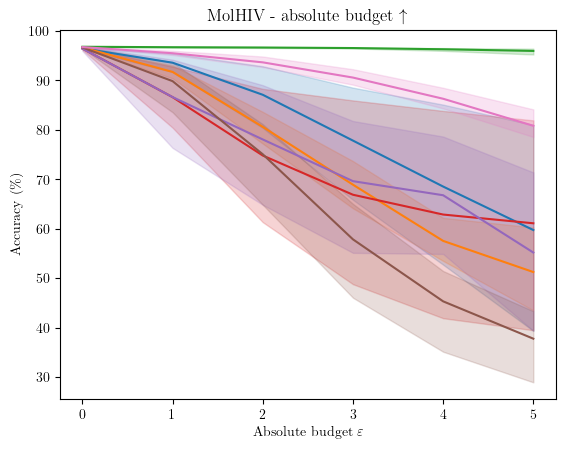

In [75]:
adjpgd_abs_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_abs"])]).copy()

per_model = group(adjpgd_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

# groupby_to_table(per_model[["model_type", "budget", "acc", "lbl_diff"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.title("MolHIV - absolute budget $\\uparrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_adjpgd_acc_abs.pgf"), bbox_inches='tight')

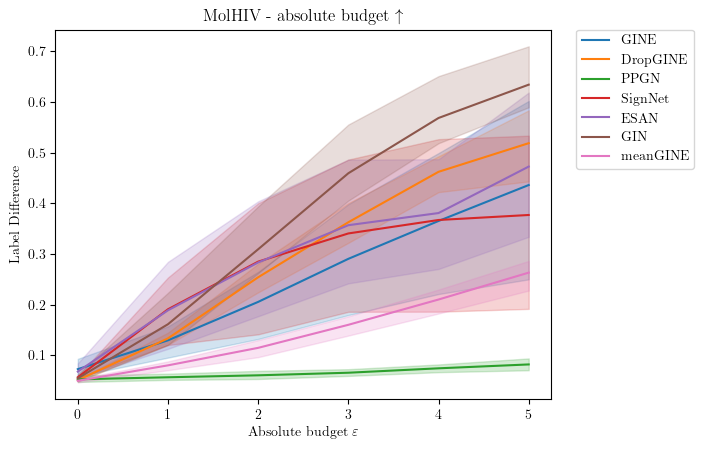

In [76]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.title("MolHIV - absolute budget $\\uparrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_adjpgd_lbl_diff_abs.pgf"), bbox_inches='tight')

## AttrPGD

In [77]:
def remove_duplicates(data, unit_ident=["model", "task", "id"]):
    data["timestamp"] = data["timestamp"].astype(str) + np.random.rand(len(data)).astype(str)
    idx = data.groupby(unit_ident)['timestamp'].transform(max) == data['timestamp']
    data = data[idx]
    data.sort_values(unit_ident, inplace=True)
    return data

def transform(df):
    if len(df)>20565:
        # df = remove_duplicates(df, unit_ident=["model", "task", "id", "budget"])
        df = df.drop_duplicates(subset=["model", "task", "id", "budget"])
    return df

attrpgd_data = load_data(all_tasks, dataset_name, ["attrpgd_abs"], apply_transform=transform)
pd.pivot_table(attrpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 5*5*4113=102825 values

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 162.27it/s]


model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
attrpgd_abs,102825,102825,102825,102825,102825,102825,102825


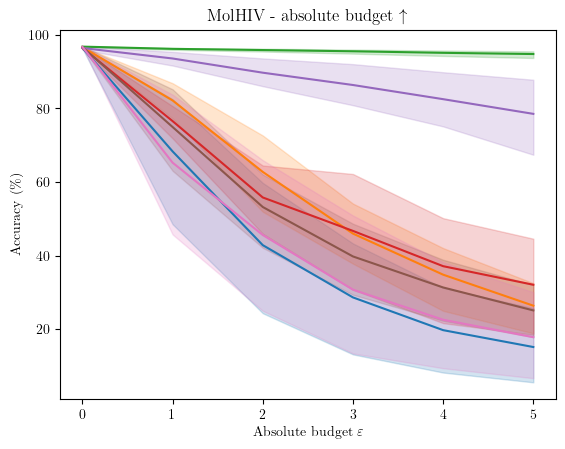

In [78]:
attrpgd_abs_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_abs"])]).copy()

per_model = group(attrpgd_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.title("MolHIV - absolute budget $\\uparrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_attrpgd_acc_abs.pgf"), bbox_inches='tight')

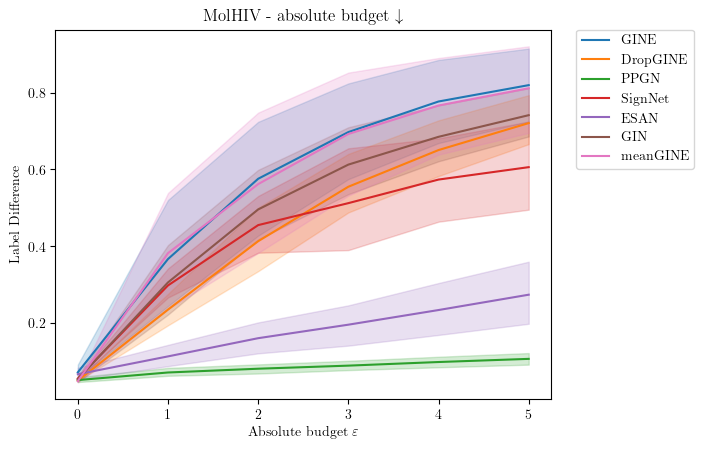

In [79]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.title("MolHIV - absolute budget $\\downarrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_attrpgd_lbl_diff_abs.pgf"), bbox_inches='tight')

## Random Perturbations

In [80]:
baseline_data = orig_data[orig_data["model_type"]=="Baseline"]
baseline_acc = baseline_data["acc"].mean()
baseline_lbl_diff = baseline_data["lbl_diff"].mean()
baseline_acc, baseline_lbl_diff

(0.9670799902747387, 0.0655206052408808)

In [81]:
def reduce_data(df):
    if len(df)>20565:
        df = df.drop_duplicates(subset=["model", "task", "id", "repeat", "budget"])

    groupby = ["model", "task", "budget"]

    per_model = group(df, groupby).mean().reset_index()
    append_model_type(per_model)
    return per_model

tasks = ["add_rdm_undir_edges", "drop_rdm_undir_edges", "rewire_rdm_undir_edges", "rdm_node_attr_change", "rdm_edge_attr_change"]
rdm_data = load_data(all_tasks, dataset_name, tasks, apply_transform=reduce_data)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


,model_type,lbl_diff
0,DropGINE,$0.262 \pm 0.186$
1,ESAN,$0.037 \pm 0.051$
2,GIN,$1.449 \pm 0.897$
3,GINE,$0.019 \pm 0.026$
4,PPGN,$0.699 \pm 0.496$
5,SignNet,$1.095 \pm 1.472$
6,meanGINE,$0.515 \pm 0.64$


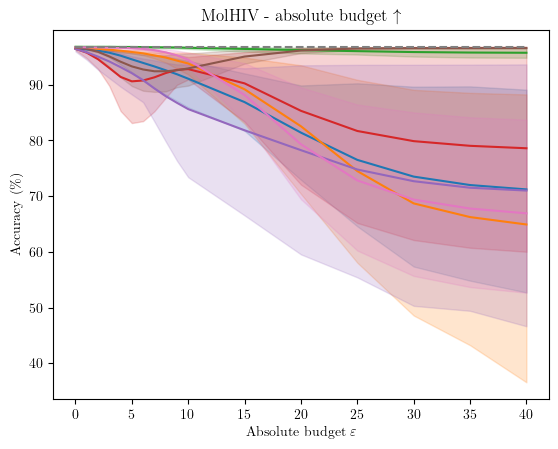

In [82]:
## ADJACENCY - ABS
adjrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_abs", "drop_rdm_undir_edges_abs"])]).copy()
adjrmd_per_model = group(adjrdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")
adjrmd_per_model = rename_col(adjrmd_per_model, "acc", "accuracy")
adjrmd_per_model["accuracy"] = 100*adjrmd_per_model["accuracy"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("MolHIV - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmadj_acc_abs.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "lbl_diff"]].groupby("model_type"))

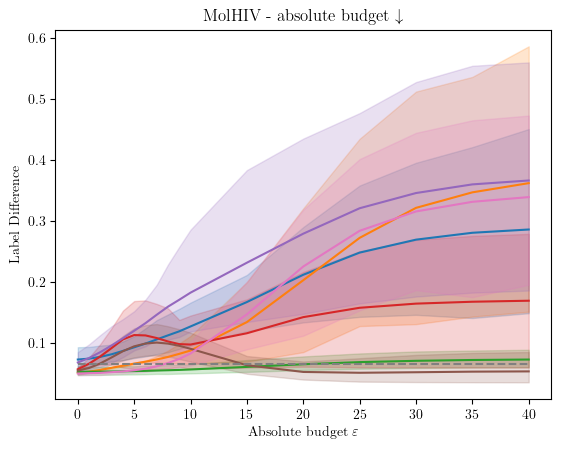

In [83]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("MolHIV - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmadj_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,lbl_diff
0,DropGINE,$0.482 \pm 0.206$
1,ESAN,$0.084 \pm 0.116$
2,GIN,$0.178 \pm 0.145$
3,GINE,$0.033 \pm 0.046$
4,PPGN,$1.163 \pm 0.686$
5,SignNet,$0.701 \pm 0.955$
6,meanGINE,$0.872 \pm 0.453$


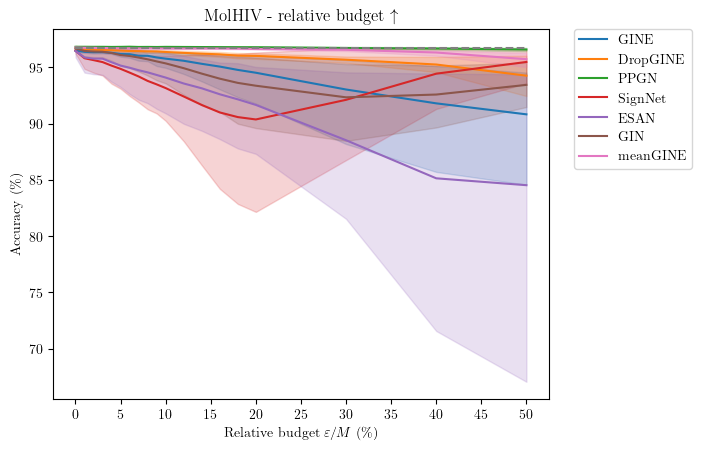

In [84]:
## ADJACENCY - REL
adjrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_rel", "drop_rdm_undir_edges_rel"])]).copy()
adjrmd_per_model = group(adjrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")
adjrmd_per_model = rename_col(adjrmd_per_model, "acc", "accuracy")
adjrmd_per_model["accuracy"] = 100*adjrmd_per_model["accuracy"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("MolHIV - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmadj_acc_rel.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "lbl_diff"]].groupby("model_type"))

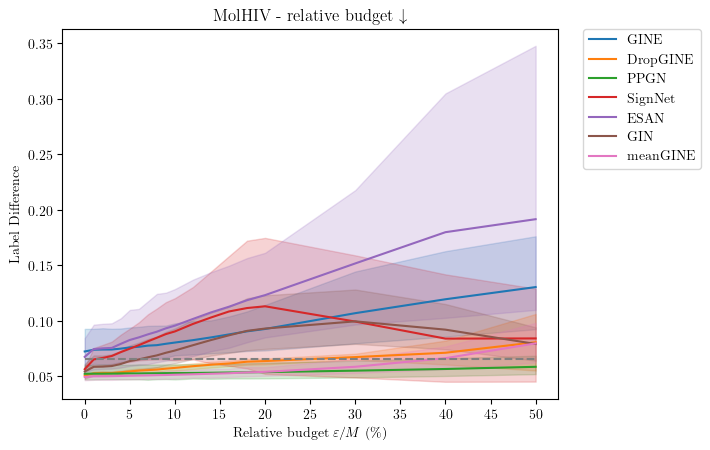

In [85]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("MolHIV - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmadj_lbl_diff_rel.pgf"), bbox_inches='tight')

,model_type,lbl_diff
0,DropGINE,$1.173 \pm 0.641$
1,ESAN,$0.325 \pm 0.611$
2,GIN,$1.125 \pm 0.777$
3,GINE,$0.863 \pm 0.914$
4,PPGN,$0.58 \pm 0.426$
5,SignNet,$0.362 \pm 0.392$
6,meanGINE,$1.029 \pm 1.05$


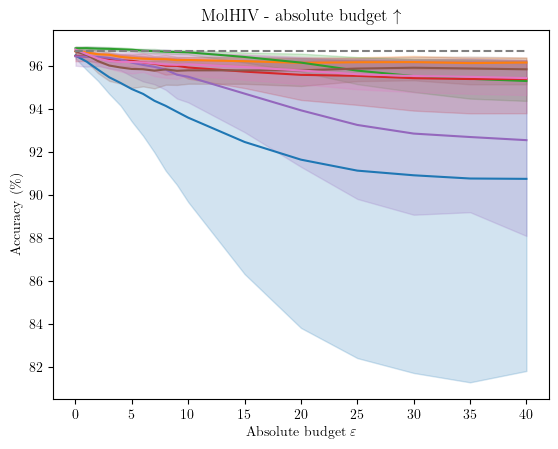

In [86]:
## ATTRIBUTES - ABS
attrrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rdm_node_attr_change_abs", "rdm_edge_attr_change_abs"])]).copy()
attrrmd_per_model = group(attrrdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(attrrmd_per_model)

attrrmd_per_model = pd.concat([attrrmd_per_model, orig_per_model]).reset_index()
attrrmd_per_model = remove_unused_categories(attrrmd_per_model[attrrmd_per_model["model_type"]!="Baseline"])
attrrmd_per_model = rename_col(attrrmd_per_model, "model_type", "model type")
attrrmd_per_model = rename_col(attrrmd_per_model, "acc", "accuracy")
attrrmd_per_model["accuracy"] = 100*attrrmd_per_model["accuracy"]

plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(attrrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("MolHIV - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmattr_acc_abs.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(attrrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(attrrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "lbl_diff"]].groupby("model_type"))

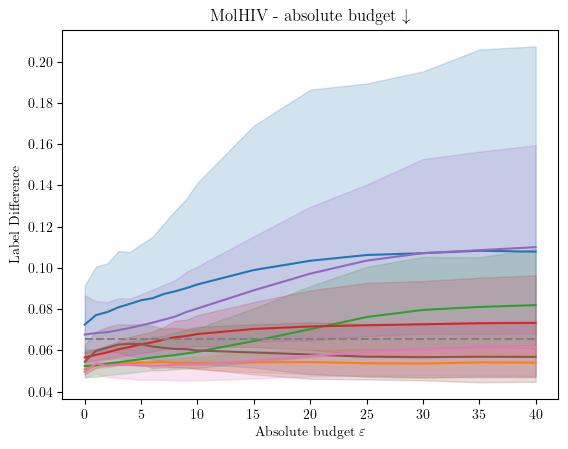

In [87]:
plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(attrrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("MolHIV - absolute budget $\\downarrow$")
plot.set_xticks([5*i for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmattr_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,lbl_diff
0,DropGINE,$1.216 \pm 0.185$
1,ESAN,$0.4 \pm 0.645$
2,GIN,$0.848 \pm 0.758$
3,GINE,$0.565 \pm 0.72$
4,PPGN,$0.94 \pm 0.592$
5,SignNet,$0.339 \pm 0.261$
6,meanGINE,$1.289 \pm 0.841$


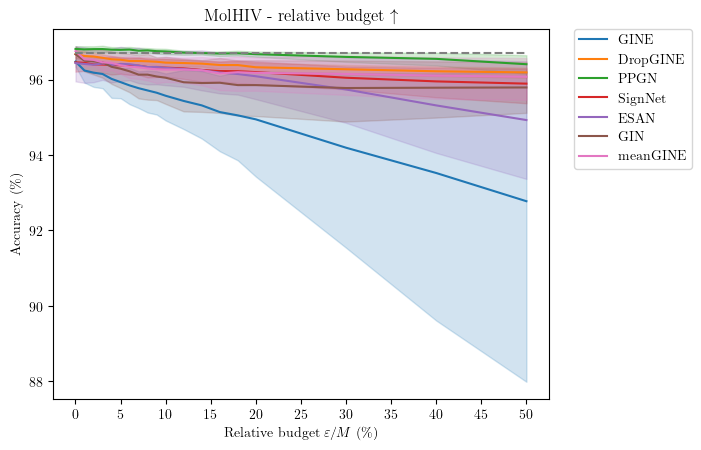

In [88]:
## ATTRIBUTES - REL
attrrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rdm_node_attr_change_rel", "rdm_edge_attr_change_rel"])]).copy()
attrrmd_per_model = group(attrrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(attrrmd_per_model)

attrrmd_per_model = pd.concat([attrrmd_per_model, orig_per_model]).reset_index()
attrrmd_per_model = remove_unused_categories(attrrmd_per_model[attrrmd_per_model["model_type"]!="Baseline"])
attrrmd_per_model = rename_col(attrrmd_per_model, "model_type", "model type")
attrrmd_per_model = rename_col(attrrmd_per_model, "acc", "accuracy")
attrrmd_per_model["accuracy"] = 100*attrrmd_per_model["accuracy"]

plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(attrrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("MolHIV - relative budget $\\uparrow$")
plot.set_xticks([5*i/100 for i in range(11)])
plot.set_xticklabels([f"{5*i}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmattr_acc_rel.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(attrrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(attrrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "lbl_diff"]].groupby("model_type"))

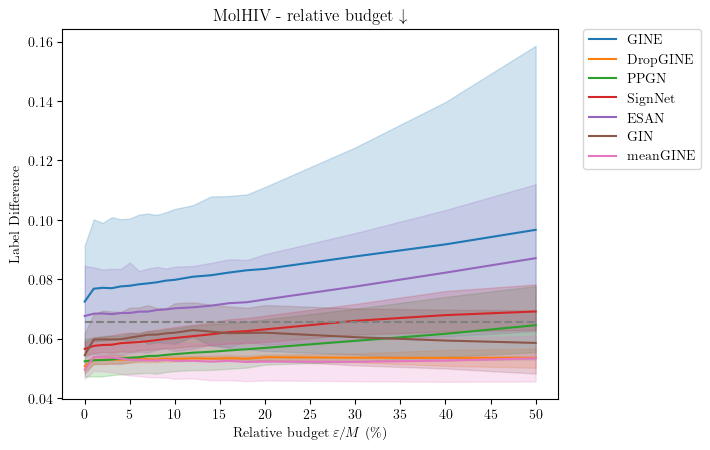

In [89]:
plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(attrrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("MolHIV - relative budget $\\downarrow$")
plot.set_xticks([5*i/100 for i in range(11)])
plot.set_xticklabels([f"{5*i}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmattr_lbl_diff_rel.pgf"), bbox_inches='tight')

,model_type,lbl_diff
0,DropGINE,$0.192 \pm 0.044$
1,ESAN,$0.051 \pm 0.072$
2,GIN,$0.154 \pm 0.136$
3,GINE,$0.026 \pm 0.038$
4,PPGN,$1.069 \pm 0.7$
5,SignNet,$0.032 \pm 0.013$
6,meanGINE,$0.784 \pm 0.439$


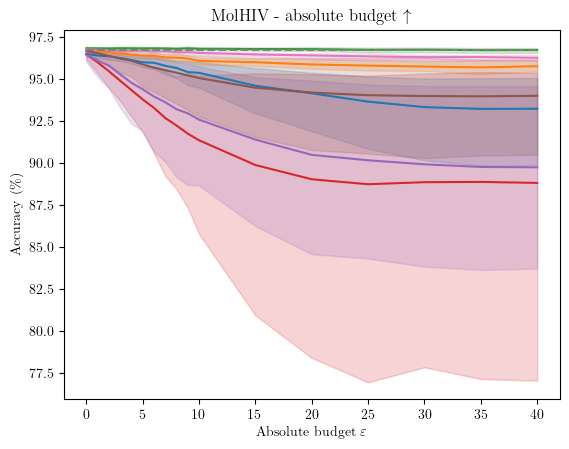

In [90]:
## REWIRE - ABS
rewirerdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_abs"])]).copy()
rewirermd_per_model = group(rewirerdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")
rewirermd_per_model = rename_col(rewirermd_per_model, "acc", "accuracy")
rewirermd_per_model["accuracy"] = 100*rewirermd_per_model["accuracy"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("MolHIV - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmrewire_acc_abs.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "lbl_diff"]].groupby("model_type"))

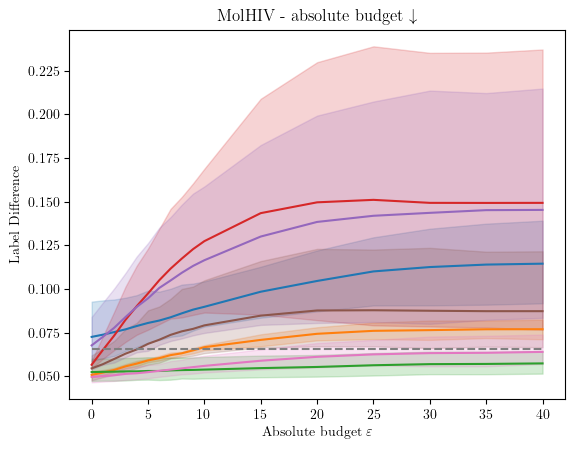

In [91]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("MolHIV - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmrewire_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,lbl_diff
0,DropGINE,$0.457 \pm 0.091$
1,ESAN,$0.127 \pm 0.178$
2,GIN,$0.388 \pm 0.365$
3,GINE,$0.054 \pm 0.078$
4,PPGN,$1.235 \pm 0.725$
5,SignNet,$0.043 \pm 0.029$
6,meanGINE,$1.168 \pm 0.494$


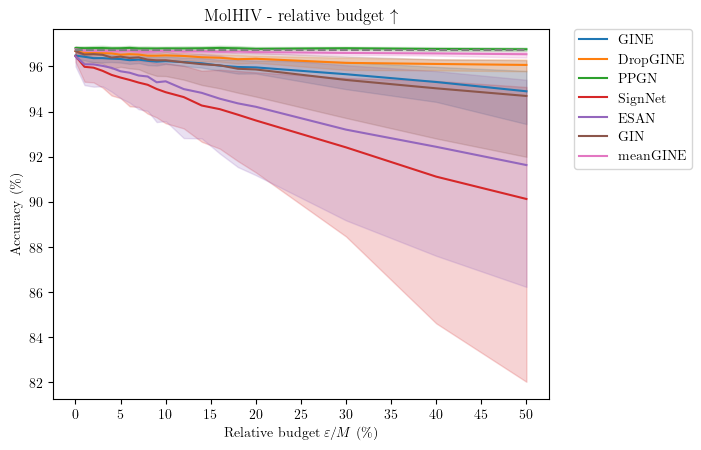

In [92]:
## REWIRE - REL
rewirerdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_rel"])]).copy()
rewirermd_per_model = group(rewirerdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")
rewirermd_per_model = rename_col(rewirermd_per_model, "acc", "accuracy")
rewirermd_per_model["accuracy"] = 100*rewirermd_per_model["accuracy"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("MolHIV - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon/ M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmrewire_acc_rel.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "lbl_diff"]].groupby("model_type"))

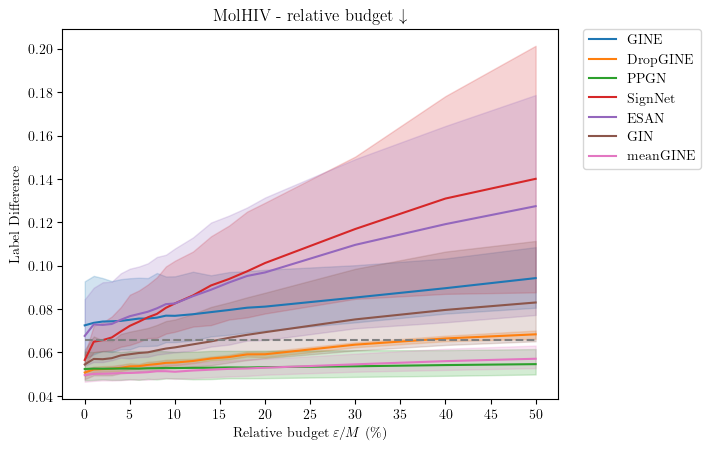

In [93]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("MolHIV - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon/ M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MolHIV_rdmrewire_lbl_diff_rel.pgf"), bbox_inches='tight')

## Comparison between PGD and BruteForce

In [94]:
## ADJACENCY COMPARISON
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_data, group_by=adjpgd_abs_data["repeat"], shared_cols=["model", "id", "budget"], target_col="lbl_diff")
adjpgd_abs_agg["task_type"] = "adj_pgd_abs"
adjpgd_df = adjpgd_abs_agg[adjpgd_abs_agg["budget"]==1][["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'pgd_lbl_diff'})

adjbf_data_ = remove_unused_categories(adjbf_data[adjbf_data["perturbation"].isin(["add-edge", "drop-edge"])]).copy()
adjbf_agg = aggregate_over_splits(adjbf_data_, group_by=adjbf_data_["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
adjbf_agg = aggregate_over_splits(adjbf_agg, group_by=adjbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "bf"
bf_df = adjbf_agg[["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'bf_lbl_diff'})

adj_comparison_df = adjpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(adj_comparison_df)
adj_comparison_df["better"] = adj_comparison_df["pgd_lbl_diff"] > adj_comparison_df["bf_lbl_diff"] - 1e-05
adj_comparison_df["lbl_diff_gap"] = adj_comparison_df["bf_lbl_diff"] - adj_comparison_df["pgd_lbl_diff"]

print(adj_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(adj_comparison_df, ["model"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "lbl_diff_gap", "better"]].groupby("model_type"))

model_type
DropGINE    20565
ESAN        20565
GIN         20565
GINE        20565
PPGN        20565
SignNet     20565
meanGINE    20565
Name: id, dtype: int64


,model_type,lbl_diff_gap,better
0,DropGINE,$0.02 \pm 0.013$,$0.394 \pm 0.042$
1,ESAN,$0.059 \pm 0.039$,$0.367 \pm 0.091$
2,GIN,$0.008 \pm 0.007$,$0.708 \pm 0.087$
3,GINE,$0.072 \pm 0.074$,$0.241 \pm 0.18$
4,PPGN,$0.02 \pm 0.007$,$0.059 \pm 0.031$
5,SignNet,$0.28 \pm 0.182$,$0.101 \pm 0.09$
6,meanGINE,$0.014 \pm 0.008$,$0.31 \pm 0.08$


In [95]:
## ATTRIBUTE COMPARISON
attrpgd_df = attrpgd_abs_data[attrpgd_abs_data["budget"]==1][["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'pgd_lbl_diff'}).copy()

attrbf_agg = aggregate_over_splits(attrbf_data, group_by=attrbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
attrbf_agg = aggregate_over_splits(attrbf_agg, group_by=attrbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
attrbf_agg["task_type"] = "bf"
bf_df = attrbf_agg[["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'bf_lbl_diff'})

attr_comparison_df = attrpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(attr_comparison_df)
attr_comparison_df["better"] = attr_comparison_df["pgd_lbl_diff"] > attr_comparison_df["bf_lbl_diff"] - 1e-05
attr_comparison_df["lbl_diff_gap"] = attr_comparison_df["bf_lbl_diff"] - attr_comparison_df["pgd_lbl_diff"]

print(attr_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(attr_comparison_df, ["model"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "lbl_diff_gap", "better"]].groupby("model_type"))

model_type
DropGINE    20565
ESAN        20565
GINE        20565
PPGN        20565
SignNet     20565
meanGINE    20565
Name: id, dtype: int64


,model_type,lbl_diff_gap,better
0,DropGINE,$0.089 \pm 0.013$,$0.244 \pm 0.047$
1,ESAN,$0.207 \pm 0.119$,$0.08 \pm 0.042$
2,GINE,$0.077 \pm 0.035$,$0.411 \pm 0.122$
3,PPGN,$0.063 \pm 0.024$,$0.042 \pm 0.007$
4,SignNet,$0.213 \pm 0.06$,$0.143 \pm 0.054$
5,meanGINE,$0.078 \pm 0.035$,$0.457 \pm 0.017$
